# Guo-Inagaki-2017 - A DataJoint example

The data and results presented in this notebook pertain to the paper:
>Zengcai V. Guo, Hidehiko K. Inagaki, Kayvon Daie, Shaul Druckmann, Charles R. Gerfen & Karel Svoboda. "Maintenance of persistent activity in a frontal thalamocortical loop" (2017) Nature
(https://dx.doi.org/10.1038/nature22324)


This notebook provide demonstrations of working with a DataJoint data pipeline in querying data, apply data conditioning and reproduce some key figures in the paper. The orignal data , in *NWB 2.0* format, had been ingested into a DataJoint data pipeline (data pipeline schema is given below). As a validation of complete ingestion of the original data into DataJoint, figures 3b,e, 6b,e and 4b,e,h will be reproduced in this example.

Data are also exported into NWB 2.0 format. See NWB export code [here](../scripts/datajoint_to_nwb.py)

In [1]:
from datetime import datetime
import os
os.chdir('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from pipeline import (reference, subject, acquisition, stimulation, analysis,
                      intracellular, extracellular, behavior, utilities)

Connecting root@127.0.0.1:3306


## A relational diagram of this data pipeline

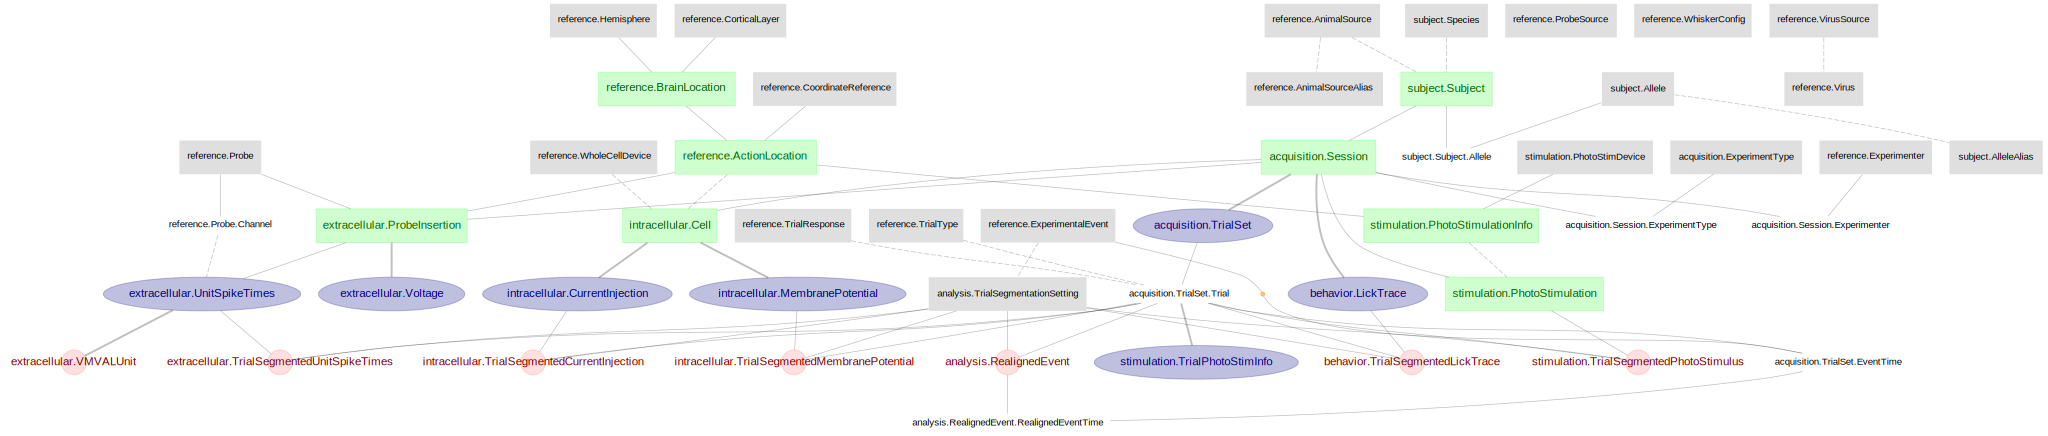

In [2]:
import datajoint as dj
all_erd = (dj.ERD(reference) + dj.ERD(subject)
           + dj.ERD(acquisition) + dj.ERD(analysis)
           + dj.ERD(stimulation) + dj.ERD(behavior)
           + dj.ERD(extracellular) + dj.ERD(intracellular))
dj.ERD(all_erd)

## Reproduce Figure 4b, e, f
First, we wish to demonstrate the queries and reproduction of figures 4b, 4e and 4h in the paper. These figures represents population-level membrane potentials of intracellular recordings, in response to photostimulation, of the entire study. To investigate the responses to photostimulation, we wish to visualize the membrane potentials responses time-locked to the onset of the "delay" period, where photostimulation was performed. This trial-based segmentation has already been performed and results stored in DataJoint, however appropriate queries are still required.  

Specifically, we need to first query membrane potentials recordings from all sessions and categorize based on: 
+ Photostim location: contralateral ALM, Thalamus, and M1
+ Trial condition: good trials without stimulation (control) and with stimulation (stim)

In this data pipeline, a recording session contains the acquired intracellular recordings, and the photostimulation, which specifies brain location the stimulation was performed on. We need to use this photostimulation information to constrain the queries of trial-segmented membrane potentials. 

In [3]:
# -- Get all whole cell
cell_keys = intracellular.Cell.fetch('KEY')

In [4]:
# -- Backtrack session, and get photostim info
# photostim keys for contra ALM stimulation
region_dict = {'brain_region':'ALM', 'hemisphere':'right'}
contraALM_photostims = (stimulation.PhotoStimulation & cell_keys & region_dict).fetch('KEY')
# photostim keys for thalamus stimulation
region_dict = {'brain_region':'VM', 'hemisphere':'left'}
thal_photostims = (stimulation.PhotoStimulation & cell_keys & region_dict).fetch('KEY')
# photostim keys for M1 stimulation
region_dict = {'brain_region':'M1', 'hemisphere':'left'}
m1_photostims = (stimulation.PhotoStimulation & cell_keys & region_dict).fetch('KEY')

In [5]:
# -- define cell restrictor for each stim location
contraALM_stim_cells = (intracellular.Cell & contraALM_photostims).fetch('KEY')
thal_stim_cells = (intracellular.Cell & thal_photostims).fetch('KEY')
m1_stim_cells = (intracellular.Cell & m1_photostims).fetch('KEY')

In [6]:
print(f'ALM cells with contra-ALM photostim: {len(contraALM_stim_cells)}')
print(f'ALM cells with thalamus photostim: {len(thal_stim_cells)}')
print(f'ALM cells with M1 photostim: {len(m1_stim_cells)}')

ALM cells with contra-ALM photostim: 9
ALM cells with thalamus photostim: 16
ALM cells with M1 photostim: 11


At this point, whole-cell recordings sessions (session-key) with photostimulation at contralateral ALM, Thalamus, and M1 are embedded in the variables *contraALM_stim_cells*, *thal_stim_cells* and *m1_stim_cells* respectively

In [7]:
# define some trial restrictor 
stim_trial_cond = 'trial_is_good = True AND trial_stim_present = True AND trial_response in ("correct", "incorrect") AND trial_type in ("lick left", "lick right")'
ctrl_trial_cond = 'trial_is_good = True AND trial_stim_present = False AND trial_response = "correct" AND trial_type in ("lick left", "lick right")'

In [8]:
# define trial-segmentation setting 
seg_param_key = (analysis.TrialSegmentationSetting & {'event': 'pole_out', 'pre_stim_duration': 1.5, 'post_stim_duration': 3}).fetch1()

In [9]:
# get sampling rate - build time vector
fs = intracellular.MembranePotential.fetch('membrane_potential_sampling_rate', limit=1)[0]
mp_tvec = np.arange(-float(seg_param_key['pre_stim_duration']), float(seg_param_key['post_stim_duration']), 1/fs)

stim_fs = (stimulation.PhotoStimulation & cell_keys).fetch('photostim_sampling_rate', limit=1)[0]
stim_tvec = np.arange(-float(seg_param_key['pre_stim_duration']), float(seg_param_key['post_stim_duration']), 1/stim_fs)

Here, for convenient operations we define a function to query trial-segmented intracellular recordings based on the session-key, and trial-restrictor defined above.
This function performs 3 steps:
1. Per trial, retrieve the Vm and photostim data, time-locked to the `pole out`
2. From the photostim data, determine the onset of photostim, defined by the 1st point exceeding 10 standard deviation.
3. Realign Vm to the estimated onset of photostim, segmented by the `pre_stim_dur` and `post_stim_dur` defined below

In [10]:
pre_stim_dur = -0.2
post_stim_dur = 1.3
tvec = np.arange(pre_stim_dur, post_stim_dur, 1/fs)

In [13]:
def query_segmented_intracellular(cells, ctrl_trial_cond, stim_trial_cond, seg_param_key):
    ctrl_trials = (intracellular.TrialSegmentedMembranePotential & cells & seg_param_key
             & (acquisition.TrialSet.Trial & ctrl_trial_cond)).fetch('KEY')
    stim_trials = (intracellular.TrialSegmentedMembranePotential & cells & seg_param_key
                 & (acquisition.TrialSet.Trial & stim_trial_cond)).fetch('KEY')
    
    aom = (stimulation.TrialSegmentedPhotoStimulus & stim_trials).fetch('segmented_photostim')
    aom = np.nanmean(np.vstack([d[:len(stim_tvec)] for d in aom]), axis=0)
    stim_onset = stim_tvec[aom > 0.8*aom[stim_tvec>0].max()][0]
    
    def make_data(trial_keys):
        for k in trial_keys:
            Vm = (intracellular.TrialSegmentedMembranePotential & k).fetch1('segmented_mp_wo_spike')[:len(mp_tvec)]

            realigned_Vm = Vm[np.logical_and(mp_tvec - stim_onset >= pre_stim_dur, mp_tvec - stim_onset < post_stim_dur)]
            
            yield realigned_Vm[:len(tvec)]
            
    # stack data across trials and cells
    return {'ctrl': np.vstack([d for d in list(make_data(ctrl_trials))]),
            'stim': np.vstack([d for d in list(make_data(stim_trials))])}

In [14]:
# query trial-segmented data based on the cell and trial restrictors    
trial_segmented_ic = {ic_loc: query_segmented_intracellular(ic_loc_key, ctrl_trial_cond, stim_trial_cond, seg_param_key)
                      for ic_loc, ic_loc_key in zip(('thalamus', 'm1', 'contraALM'), (thal_stim_cells, m1_stim_cells, contraALM_stim_cells))}

In [43]:
def plot_with_sem(data1, data2, tvec, ax):
    for d, c, s in zip((data1, data2), ('b', 'k'), ('b', 'gray')):
        v_mean = np.nanmean(d, axis=0)
        v_sem = np.nanstd(d, axis=0) / np.sqrt(d.shape[0])
        ax.plot(tvec[:len(v_mean)], v_mean, c)
        ax.fill_between(tvec[:len(v_mean)], v_mean - v_sem, v_mean + v_sem, alpha=0.5, facecolor=s)          
    ax.axvline(x=0, linestyle='--', color='k')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

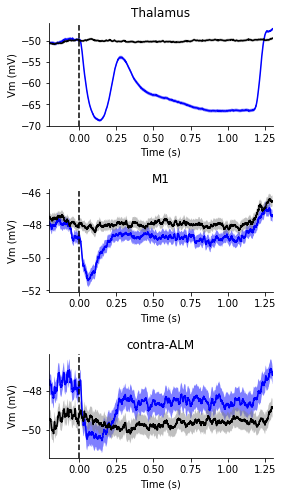

In [16]:
# plot
fig4, axs = plt.subplots(len(trial_segmented_ic), 1, figsize=(4, 8))
fig4.subplots_adjust(hspace=0.6)

for avg, ax, title in zip(trial_segmented_ic.values(), axs, ('Thalamus', 'M1', 'contra-ALM')):
    plot_with_sem(avg['stim'], avg['ctrl'], tvec, ax)
    ax.set_xlim(pre_stim_dur, post_stim_dur)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Vm (mV)')
    ax.set_title(title)

## Reproduce Figure 3b, 6b - Extracellular
The following parts of this example relates to the extracellular recording results of this study, namedly the neuronal spiking patterns in response to photostimulation 

Fairly similar to the routine layed out above, we wish to query neuronal spike times, segmented time-locked to the "delay" period, categorized by recording locations and photostimulation locations:
+ Record at ALM, stimulation at ALM
+ Record at ALM, stimulation at Thalamus
+ Record at Thalamus, stimulation at Thalamus
+ Record at Thalamus, stimulation at ALM

Also with two trial-based conditions: good trials without stimulation (control) and with stimulation (stim)

In [17]:
# get trial-segmented spiketimes for a single unit in the one specifed session
def query_unit_segmented_spiketimes(sess_key, unit, trial_key, seg_param_key):
    data_keys = (extracellular.TrialSegmentedUnitSpikeTimes & sess_key & {'unit_id': unit} & seg_param_key &
                 ((acquisition.TrialSet.Trial & trial_key) & (stimulation.TrialPhotoStimInfo & trial_key))).fetch('KEY')
    return pd.DataFrame([dict(**dict(zip(*(analysis.RealignedEvent.RealignedEventTime & k).fetch('trial_event', 'realigned_event_time'))), 
                 segmented_spike_times=(extracellular.TrialSegmentedUnitSpikeTimes & k).fetch1(
                     'segmented_spike_times')) for k in data_keys])

In [18]:
def plot_spike_raster_and_histogram(contra_spike_times, ipsi_spike_times, axes, ax_title='', bin_counts=200, shade_bar=False):
    # get event timing
    events = ['pole_in', 'pole_out', 'cue_start']
    event_times = np.around([np.median(np.hstack([ipsi_spike_times[e], contra_spike_times[e]])) for e in events], 4)
    
    # restructure data for spike raster  
    ipsi_c_trial_idx, ipsi_c_spike_times = zip(*((np.full_like(r, ri), r)
                                            for ri, r in enumerate(r for r in ipsi_spike_times.segmented_spike_times if len(r) != 0)))
    ipsi_c_trial_idx = np.hstack(ipsi_c_trial_idx)
    ipsi_c_spike_times = np.hstack(ipsi_c_spike_times)    
    
    contra_c_trial_idx, contra_c_spike_times = zip(*((np.full_like(r, ri), r)
                                            for ri, r in enumerate(r for r in contra_spike_times.segmented_spike_times if len(r) != 0)))
    contra_c_trial_idx = np.hstack(contra_c_trial_idx)
    contra_c_spike_times = np.hstack(contra_c_spike_times)  
    
    # spiketime histogram
    time_range = (np.hstack([ipsi_spike_times.trial_start, contra_spike_times.trial_start]).min(),
                  np.hstack([ipsi_spike_times.trial_stop, contra_spike_times.trial_stop]).max())

    ipsi_spk_counts, ipsi_edges = np.histogram(np.hstack([r for r in ipsi_spike_times.segmented_spike_times]),
                                       bins=bin_counts,
                                       range=(time_range[0], time_range[-1]))
    ipsi_spk_rates = ipsi_spk_counts / np.diff(ipsi_edges) / ipsi_spike_times.segmented_spike_times.shape[0]
    
    contra_spk_counts, contra_edges = np.histogram(np.hstack([r for r in contra_spike_times.segmented_spike_times]),
                                       bins=bin_counts,
                                       range=(time_range[0], time_range[-1]))
    contra_spk_rates = contra_spk_counts / np.diff(contra_edges) / contra_spike_times.segmented_spike_times.shape[0]
   
    # plot
    # spike raster
    ax_top = axes[0]
    ax_top.plot(contra_c_spike_times, contra_c_trial_idx , '|b', markersize=2)
    ax_top.plot(ipsi_c_spike_times, ipsi_c_trial_idx + contra_c_trial_idx.max(), '|r', markersize=2)
    # event markers
    for e in event_times:
        ax_top.axvline(x=e, linestyle='--', color='k')
    ax_top.set_xticklabels([])
    ax_top.set_yticklabels([])
    ax_top.set_ylabel(ax_title)
    ax_top.set_xlim(-1.5, 2.5);
    
    # spike histogram
    ax_bot = axes[1]
    ax_bot.plot(contra_edges[1:], contra_spk_rates, 'b')
    ax_bot.plot(ipsi_edges[1:], ipsi_spk_rates, 'r')
    for e in event_times:
        ax_bot.axvline(x=e, linestyle='--', color='k')
    ax_bot.set_xlim(-1.5, 2.5);
    
    # shade-bar for photostim
    if shade_bar:
        for ax in axes:
            ax.axvspan(event_times[1], event_times[1] + 1.2, 0.95, 1, alpha = 0.3, color = 'royalblue')
    
    # Hide the spines
    ax_top.spines['right'].set_visible(False)
    ax_top.spines['top'].set_visible(False)
    ax_top.spines['left'].set_visible(False)
    ax_top.spines['bottom'].set_visible(False)
    ax_bot.spines['right'].set_visible(False)
    ax_bot.spines['top'].set_visible(False)

In [51]:
# blue - correct contra trial (licking-right) ; red - correct ipsi trial (licking left); and photostim_period at 'delay' period
correct_contra_trial_stim =  {'trial_is_good': True, 'trial_stim_present': True,
                              'trial_type': 'lick right', 'photo_stim_period': 'delay'}
correct_ipsi_trial_stim =  {'trial_is_good': True, 'trial_stim_present': True,
                            'trial_type': 'lick left', 'photo_stim_period': 'delay'}
correct_contra_trial_ctrl =  {'trial_is_good': True, 'trial_stim_present': False, 'trial_type': 'lick right'}
correct_ipsi_trial_ctrl =  {'trial_is_good': True, 'trial_stim_present': False, 'trial_type': 'lick left'}

ec_alm_insert = (extracellular.ProbeInsertion & {'brain_region': 'ALM', 'hemisphere': 'left'})
ec_thal_insert = (extracellular.ProbeInsertion & {'brain_region': 'thalamus', 'hemisphere': 'left'})

alm_photostim = (stimulation.PhotoStimulation & {'brain_region': 'ALM', 'hemisphere': 'left'})
thal_photostim = (stimulation.PhotoStimulation & {'brain_region': 'thalamus', 'hemisphere': 'left'})

# ALM probe with ALM or Thalamus photostim
alm_insert_alm_stim = (acquisition.Session & ec_alm_insert) & (acquisition.Session & alm_photostim).fetch('KEY')
alm_insert_thal_stim = (acquisition.Session & ec_alm_insert) & (acquisition.Session & thal_photostim).fetch('KEY')
# Thalamus probe with ALM or Thalamus photostim
thal_insert_alm_stim = (acquisition.Session & ec_thal_insert) & (acquisition.Session & alm_photostim).fetch('KEY')
thal_insert_thal_stim = (acquisition.Session & ec_thal_insert) & (acquisition.Session & thal_photostim).fetch('KEY')

### Example unit - Fig 3b & 6b
We pick some arbitrary neuronal units for plotting the spike raster and spike histogram

In [20]:
# # Chery-picking unit and session...
# for idx, sess in enumerate(alm_insert_thal_stim.fetch('KEY')): # pick one session here
#     print([idx, len(acquisition.TrialSet.Trial & sess & correct_contra_trial_stim),
#            len(acquisition.TrialSet.Trial & sess & correct_ipsi_trial_stim)])

In [21]:
# get segmented spike times for one unit - ALM-insert, thal-stim
def make_unit_spiketimes(unit, sess):
    return {k: query_unit_segmented_spiketimes(sess, unit, v, seg_param_key) 
            for k, v in zip(('contra_ctrl', 'ipsi_ctrl', 'contra_stim', 'ipsi_stim'), 
                            (correct_contra_trial_ctrl, correct_ipsi_trial_ctrl, 
                             correct_contra_trial_stim, correct_ipsi_trial_stim))}

In [22]:
# 3 units with ALM insert and Thalamus photostim
s1 = (alm_insert_thal_stim & {'subject_id': 'anm00322807', 'session_time': '2017-06-27 09:43:03'}).fetch1('KEY')  #20151235
s2 = (alm_insert_thal_stim & {'subject_id': 'anm00322805', 'session_time': '2017-06-27 09:42:26'}).fetch1('KEY')  #20151202
s3 = (alm_insert_thal_stim & {'subject_id': 'anm00322807', 'session_time': '2017-06-27 09:43:07'}).fetch1('KEY')  #20151263
alm_insert_thal_stim_unit = [make_unit_spiketimes(unit=unit_no, sess=session_no)
                             for unit_no, session_no in zip((18, 19, 9), (s1, s2, s3))]

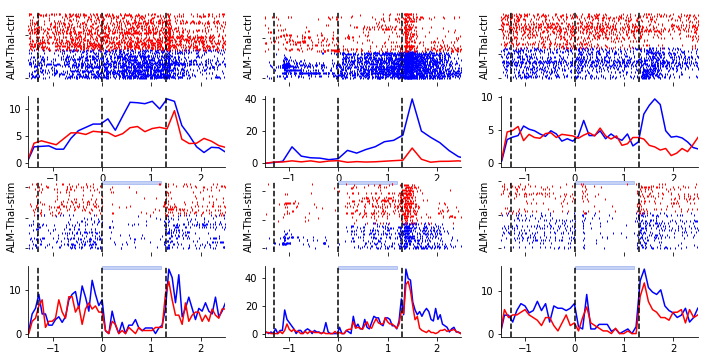

In [23]:
# spike raster and histogram - Fig 3b
bin_counts = 200
unit_count = len(alm_insert_thal_stim_unit)
fig3, axs = plt.subplots(4, unit_count, figsize=(12, 6))
for u_idx, unit_spiketimes in enumerate(alm_insert_thal_stim_unit):
    plot_spike_raster_and_histogram(unit_spiketimes['contra_ctrl'], unit_spiketimes['ipsi_ctrl'], 
                                    axes = (axs.flatten()[u_idx + unit_count*0], axs.flatten()[u_idx + unit_count*1]),
                                    ax_title='ALM-Thal-ctrl', bin_counts=bin_counts)
    plot_spike_raster_and_histogram(unit_spiketimes['contra_stim'], unit_spiketimes['ipsi_stim'], 
                                    axes = (axs.flatten()[u_idx + unit_count*2], axs.flatten()[u_idx + unit_count*3]),
                                    ax_title='ALM-Thal-stim', bin_counts=bin_counts, shade_bar=True)

In [24]:
# # Chery-picking unit and session...
# for idx, sess in enumerate(thal_insert_alm_stim.fetch('KEY')): # pick one session here
#     print([idx, len(acquisition.TrialSet.Trial & sess & correct_contra_trial_stim),
#            len(acquisition.TrialSet.Trial & sess & correct_ipsi_trial_stim)])

In [25]:
# 3 units with Thalamus insert and ALM photostim
s1 = (thal_insert_alm_stim & {'subject_id': 'anm00260487', 'session_time': '2017-06-27 09:36:39'}).fetch1('KEY')  #20141007
s2 = (thal_insert_alm_stim & {'subject_id': 'anm00234218', 'session_time': '2017-06-27 09:35:21'}).fetch1('KEY')  #20140617
s3 = (thal_insert_alm_stim & {'subject_id': 'anm00260487', 'session_time': '2017-06-27 09:36:48'}).fetch1('KEY')  #20141043
thal_insert_alm_stim_unit = [make_unit_spiketimes(unit=unit_no, sess=session_no)
                             for unit_no, session_no in zip((5, 3, 8), (s1, s2, s3))]

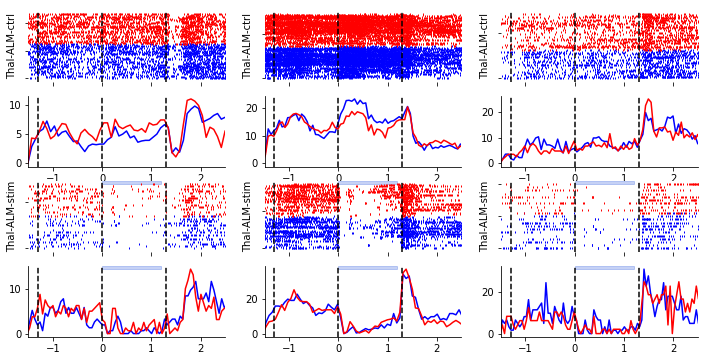

In [26]:
# spike raster and histogram - Fig 6b
bin_counts = 250
unit_count = len(thal_insert_alm_stim_unit)
fig3, axs = plt.subplots(4, unit_count, figsize=(12, 6))
for u_idx, unit_spiketimes in enumerate(thal_insert_alm_stim_unit):
    plot_spike_raster_and_histogram(unit_spiketimes['contra_ctrl'], unit_spiketimes['ipsi_ctrl'], 
                                    axes = (axs.flatten()[u_idx + unit_count*0], axs.flatten()[u_idx + unit_count*1]),
                                    ax_title='Thal-ALM-ctrl', bin_counts=bin_counts)
    plot_spike_raster_and_histogram(unit_spiketimes['contra_stim'], unit_spiketimes['ipsi_stim'], 
                                    axes = (axs.flatten()[u_idx + unit_count*2], axs.flatten()[u_idx + unit_count*3]),
                                    ax_title='Thal-ALM-stim', bin_counts=bin_counts, shade_bar=True)

## Population - Fig 3e and 6e
Similarly, for the entire population, instead of picking a few representative units for plotting, here we will query all units from all sessions constrained by:
1. The recording/stimulation brain regions
    + ALM recording with photostim at Thalamus - only pyramidal neurons
    + ALM recording with photostim at ALM - only pyramidal neurons
    + Thalamus recording with photostim at Thalamus - filter to VM/VAL neurons only
    + Thalamus recording with photostim at ALM - select all thalamus neurons
2. The trial-condition
    + good trial
    + with/without photostim

The routines for plotting the spike histogram is analogous to that above. 

In [60]:
seg_param_key

{'trial_seg_setting': 0,
 'event': 'pole_out',
 'pre_stim_duration': Decimal('1.50'),
 'post_stim_duration': Decimal('3.00')}

In [65]:
# get trial-segmented spiketimes for all units in all specifed sessions
def extract_segmented_spiketimes_histogram(units, trial_cond, seg_param_key, time_range=(-1.5, 3), bin_counts=1000):
    unit_keys = units.fetch('KEY')
    print(f'Found {len(unit_keys)} units')     
    
    def make_spike_histogram():
        for idx, unit_key in tqdm(enumerate(unit_keys)):
            trial_spikes = (extracellular.TrialSegmentedUnitSpikeTimes & unit_key &
                                         ((acquisition.TrialSet.Trial & trial_cond)
                                          & (stimulation.TrialPhotoStimInfo & trial_cond)))
            # Verify if a unit has at least 5 trials, if not then exclude
            if len(trial_spikes) > 5:   
                trial_spikes = trial_spikes.fetch('segmented_spike_times')
                segmented_spike_times = np.hstack([spks for spks in trial_spikes])
                if segmented_spike_times.size > 0:
                    spk_counts, spk_edges = np.histogram(segmented_spike_times, bins=bin_counts, range=time_range)
                    yield spk_counts / np.diff(spk_edges) / len(trial_spikes), spk_edges[1:]
     
    output = {'data': np.vstack([x[0] for x in make_spike_histogram()]),
              'timestamps': next(make_spike_histogram())[1]}    
    return output

In [53]:
# get segmented spike times for population - ALM/thal-insert, thal-stim
stim_trial =  {'trial_is_good': True, 'trial_stim_present': True, 'photo_stim_period': 'delay'}
ctrl_trial =  {'trial_is_good': True, 'trial_stim_present': False}

### Apply selection of putative pyramidal neurons, or VM/VAL neurons only

In [70]:
# extract matched units
alm_insert_thal_stim_units = extracellular.UnitSpikeTimes & alm_insert_thal_stim & 'unit_cell_type = "wide width spiking"'
alm_insert_alm_stim_units = extracellular.UnitSpikeTimes & alm_insert_alm_stim & 'unit_cell_type = "wide width spiking"'
thal_insert_thal_stim_units = extracellular.UnitSpikeTimes & thal_insert_thal_stim & 'unit_cell_type = "wide width spiking"'
thal_insert_alm_stim_units =  extracellular.UnitSpikeTimes * extracellular.VMVALUnit & thal_insert_alm_stim & 'in_vmval = True'

In [71]:
population_spikes = {name_k: {'ctrl': extract_segmented_spiketimes_histogram(sess_k, ctrl_trial, seg_param_key,
                                                               (-0.2, 0.5), 500),
                          'stim': extract_segmented_spiketimes_histogram(sess_k, stim_trial, seg_param_key,
                                                               (-0.2, 0.5), 500)}
                 for name_k, sess_k in zip(('alm_neurons-thal_stim', 'thal_neurons-thal_stim', 
                                            'VMVAL_neurons-alm_stim', 'alm_neurons-alm_stim'),
                                           (alm_insert_thal_stim_units, thal_insert_thal_stim_units, 
                                            thal_insert_alm_stim_units, alm_insert_alm_stim_units))}

Found 645 units


645it [00:25, 24.49it/s]
0it [00:00, ?it/s]


Found 645 units


645it [00:16, 39.07it/s]
0it [00:00, ?it/s]


Found 127 units


127it [00:04, 25.57it/s]
0it [00:00, ?it/s]


Found 127 units


127it [00:03, 41.83it/s]
0it [00:00, ?it/s]


Found 179 units


179it [00:08, 21.72it/s]
0it [00:00, ?it/s]


Found 179 units


179it [00:04, 36.26it/s]
0it [00:00, ?it/s]


Found 165 units


165it [00:06, 25.00it/s]
0it [00:00, ?it/s]


Found 165 units


165it [00:04, 39.92it/s]
0it [00:00, ?it/s]


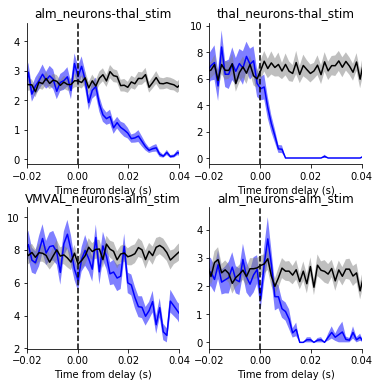

In [73]:
fig36, axs = plt.subplots(2, 2, figsize=(6, 6))
fig36.subplots_adjust(hspace=0.3)
for s, ax in zip(population_spikes.keys(), axs.flatten()):
    plot_with_sem(population_spikes[s]['stim']['data'],
                  population_spikes[s]['ctrl']['data'],
                  population_spikes[s]['ctrl']['timestamps'], ax)
    ax.set_xlim(-0.02, 0.04);
    ax.set_title(s)
    ax.set_xlabel('Time from delay (s)')